In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [13]:
# bring in data
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

# prepare data
def prepare_and_split_data(data, test_size = 0.15):
    data = data.sort_values('date')
    data = data[['date', 'new_confirmed']].copy() 
    zero = data[data['new_confirmed'] != 0].iloc[0]['date']
    data = data[data['date'] >= zero]
    data.set_index('date', inplace=True)
    data.sort_index(inplace=True)
    data.index = pd.to_datetime(data.index)
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(enc_test))

midatl_train

Length enc train:  821
Length enc test:  145


,new_confirmed
date,
2020-03-03,1.0
2020-03-04,0.0
2020-03-05,4.0
2020-03-06,26.0
2020-03-07,13.0
...,...
2022-04-24,7076.0
2022-04-25,12165.0
2022-04-26,9065.0


In [49]:
def search_auto_arima(train, test, m = [1, 2, 7], max_q = 21, max_p = 14, max_Q = 21, max_P = 14, max_d = 2, max_D = 2, region = "East North Central"): 
    models = {}
    for val in m:
        auto_model = auto_arima(train['new_confirmed'], seasonal=True, m=val, suppress_warnings=True, stepwise=True, max_q=max_q, max_p=max_p, max_Q = max_Q, max_P = max_P, max_d = max_d, max_D = max_D)
        # n_periods = len(test['new_confirmed'])
        # forecast = auto_model.predict(n_periods=n_periods)
        # actuals = test['new_confirmed']

        # mae = mean_absolute_error(actuals, forecast)
        # rmse = np.sqrt(mean_squared_error(actuals, forecast))
        # mase = mean_absolute_scaled_error(actuals, forecast, y_train=train['new_confirmed'])
        aic = auto_model.aic()
        print('m = ', val, " done")
        print(aic)
        models[val] = (auto_model, aic, val, auto_model.order, auto_model.seasonal_order)
    best_model = min(models, key = lambda k: models[k][1])
    model, aic, val, order, season = models[best_model]
    n_periods = len(test['new_confirmed'])
    forecast = auto_model.predict(n_periods=n_periods)
    forecast = [0 if x < 0 else x for x in forecast]
    actuals = test['new_confirmed']

    mae = mean_absolute_error(actuals, forecast)
    rmse = np.sqrt(mean_squared_error(actuals, forecast))
    mase = mean_absolute_scaled_error(actuals, forecast, y_train=train['new_confirmed'])

    print('M = ', val)
    print(order)
    print(season)
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MASE: {mase}")
    print(model.summary())

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['new_confirmed'], label='New Cases')
    plt.plot(test['new_confirmed'].index, forecast, label='Predicted New Cases')
    plt.title("New Cases and Predictions for the " + str(region) + " Region")
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.show()

# ENC

m =  1  done
17357.922971156666
m =  2  done
18116.203583278293
m =  7  done
17363.824943355696
M =  1
(7, 1, 5)
(0, 0, 0, 0)
MAE: 8140.338312266141
RMSE: 9982.127632302525
MASE: 1.0242239450896873
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  821
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8665.961
Date:                Tue, 12 Mar 2024   AIC                          17357.923
Time:                        00:24:19   BIC                          17419.144
Sample:                    01-24-2020   HQIC                         17381.414
                         - 04-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       

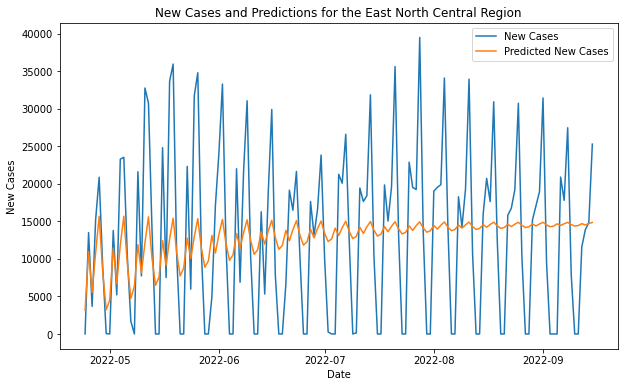

In [40]:
search_auto_arima(enc_train, enc_test)

In [8]:
# auto_model = auto_arima(enc_train['new_confirmed'], seasonal=True, m=1, suppress_warnings=True, stepwise=True, max_q=7, max_p=7, max_Q = 7, max_P = 7)

# n_periods = len(enc_test['new_confirmed'])
# forecast = auto_model.predict(n_periods=n_periods)

# actuals = enc_test['new_confirmed']

# mae = mean_absolute_error(actuals, forecast)

# rmse = np.sqrt(mean_squared_error(actuals, forecast))

# y_train = enc_train['new_confirmed']
# mase = mean_absolute_scaled_error(actuals, forecast, y_train=y_train)

# print(f"MAE: {mae}")
# print(f"RMSE: {rmse}")
# print(f"MASE: {mase}")

# print(auto_model.summary())

MAE: 9194.052195112905
RMSE: 11269.654462297894
MASE: 1.1593044177024705
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(7, 1, 5)   Log Likelihood               -8676.015
Date:                Sat, 02 Mar 2024   AIC                          17378.030
Time:                        12:19:41   BIC                          17439.266
Sample:                             0   HQIC                         17401.525
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0219      0.025     -0.889      0.374      -0.070       0.026
ar.L2         -0.0035      0.026     -0.136      0.892    

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


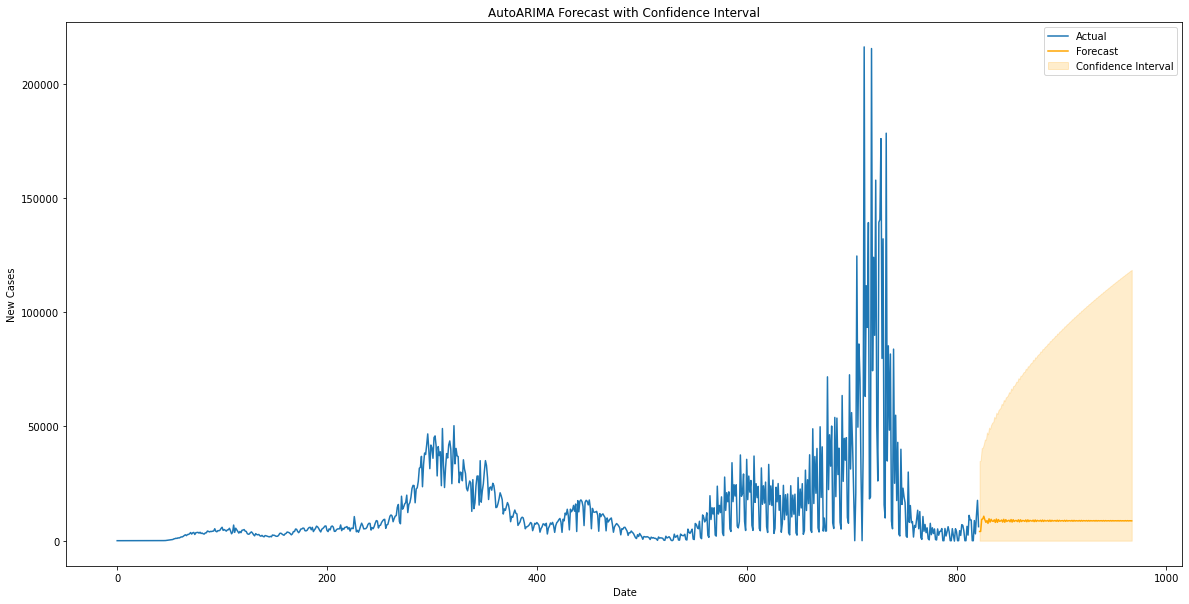

In [11]:
# forecast, conf_int = auto_model.predict(n_periods=len(enc_test), return_conf_int=True)
# for i in conf_int:
#     if i[0] < 0:
#         i[0] = 0

# #test_dates =  #pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
# plt.figure(figsize= (20,10))
# plt.plot(np.array(enc_train.index), np.array(enc_train['new_confirmed']), label='Actual')

# plt.plot(np.array(enc_test.index), np.array(forecast), label='Forecast', color='orange')

# plt.fill_between(enc_test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# plt.title('AutoARIMA Forecast with Confidence Interval')
# plt.xlabel('Date')
# plt.ylabel('New Cases')
# plt.legend()
# plt.show()

In [20]:
# def log_transform(x):
#     return np.log(x) if x > 0 else 0

# log_auto_model = auto_arima(enc_train['new_confirmed'].apply(lambda x: log_transform(x)), seasonal=True, m=1, suppress_warnings=True, stepwise=True, max_q=4, max_p=4, max_Q = 4, max_P = 4)
# print(log_auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  822
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -1103.283
Date:                Fri, 23 Feb 2024   AIC                           2224.567
Time:                        11:10:27   BIC                           2266.962
Sample:                             0   HQIC                          2240.833
                                - 822                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8526      0.017     51.008      0.000       0.820       0.885
ar.L2         -1.3263      0.022    -60.445      0.000      -1.369      -1.283
ar.L3          0.6824      0.019     35.528      0.0

/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


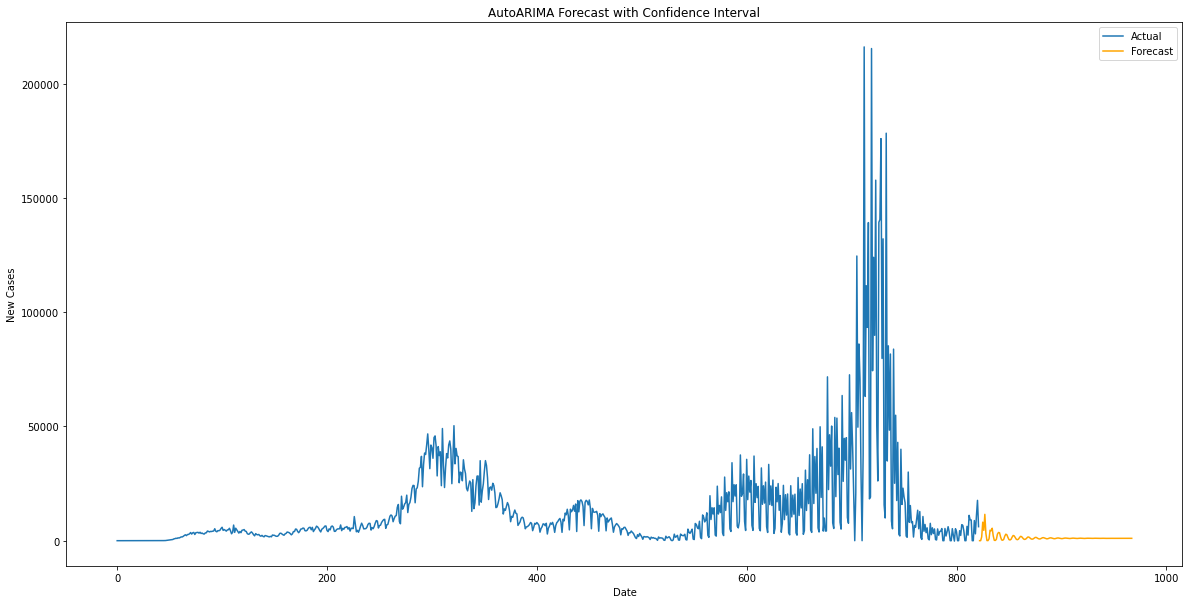

In [28]:
# forecast, conf_int = log_auto_model.predict(n_periods=len(enc_test), return_conf_int=True)
# forecast = np.exp(forecast)
# conf_int = np.exp(conf_int)
# # for i in conf_int:
# #     if i[0] < 0:
# #         i[0] = 0

# #test_dates =  #pd.date_range(df.index[-1], periods=n_periods + 1, freq=df.index.freq)[-n_periods:]
# plt.figure(figsize= (20,10))
# plt.plot(np.array(enc_train.index), np.array(enc_train['new_confirmed']), label='Actual')

# plt.plot(np.array(enc_test.index), np.array(forecast), label='Forecast', color='orange')

# # plt.fill_between(enc_test.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

# plt.title('AutoARIMA Forecast with Confidence Interval')
# plt.xlabel('Date')
# plt.ylabel('New Cases')
# plt.legend()
# plt.show()

# ESC

m =  1  done
15784.426151532678
m =  2  done
15909.265451138808
m =  7  done
15787.309275228585
M =  1
(8, 1, 4)
(0, 0, 0, 0)
MAE: 5243.622296875435
RMSE: 7841.13156327345
MASE: 1.5113658533822363
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  787
Model:               SARIMAX(8, 1, 4)   Log Likelihood               -7879.213
Date:                Tue, 12 Mar 2024   AIC                          15784.426
Time:                        00:28:39   BIC                          15845.097
Sample:                    03-04-2020   HQIC                         15807.752
                         - 04-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        

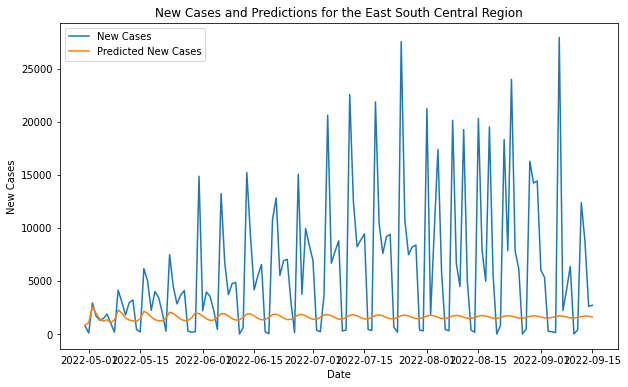

In [41]:
search_auto_arima(esc_train, esc_test, region = "East South Central")

# MidAtl

m =  1  done
15722.687707479075
m =  2  done
15598.846516703636
m =  7  done
15483.349562456744
M =  7
(6, 1, 3)
(3, 0, 0, 7)
MAE: 8494.21318625126
RMSE: 10124.173480990197
MASE: 3.7906793773358656
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  787
Model:             SARIMAX(6, 1, 3)x(3, 0, [], 7)   Log Likelihood               -7728.675
Date:                            Tue, 12 Mar 2024   AIC                          15483.350
Time:                                    01:13:28   BIC                          15544.020
Sample:                                03-03-2020   HQIC                         15506.676
                                     - 04-28-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.

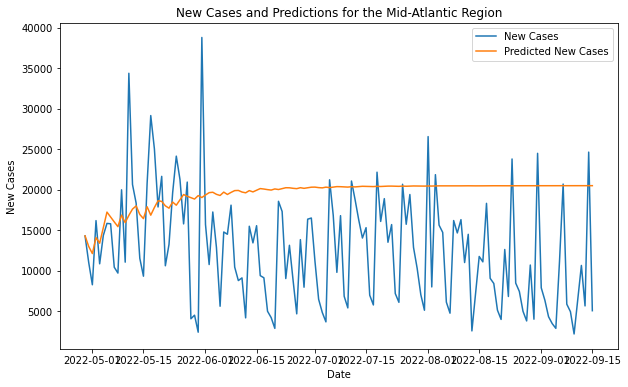

In [52]:
search_auto_arima(midatl_train, midatl_test, region = "Mid-Atlantic")

# Mountain

m =  1  done
16712.157511877755
m =  2  done
16740.26677550108
m =  7  done
16508.634552107018
M =  7
(3, 1, 3)
(2, 0, 2, 7)
MAE: 4628.459781720476
RMSE: 7666.793163732182
MASE: 1.456919838567519
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  819
Model:             SARIMAX(3, 1, 3)x(2, 0, [1, 2], 7)   Log Likelihood               -8243.317
Date:                                Tue, 12 Mar 2024   AIC                          16508.635
Time:                                        00:37:00   BIC                          16560.410
Sample:                                    01-26-2020   HQIC                         16528.503
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z 

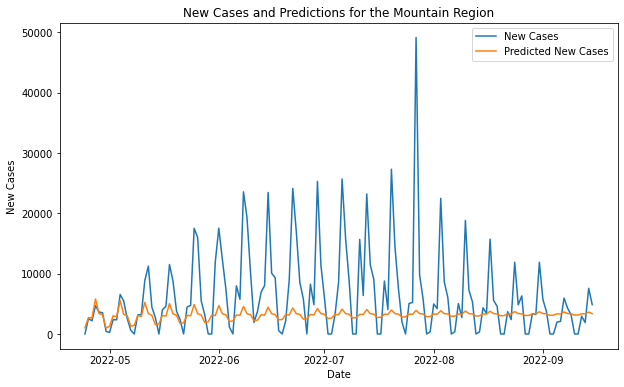

In [43]:
search_auto_arima(mount_train, mount_test, region = "Mountain")

# New England

m =  1  done
15831.949700270092
m =  2  done
15999.017195473472
m =  7  done
15561.075017595103
M =  7
(6, 1, 3)
(1, 0, 1, 7)
MAE: 5285.842321405798
RMSE: 5897.420910333565
MASE: 2.0095240360086986
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  788
Model:             SARIMAX(6, 1, 3)x(1, 0, [1], 7)   Log Likelihood               -7768.538
Date:                             Tue, 12 Mar 2024   AIC                          15561.075
Time:                                     00:39:57   BIC                          15617.094
Sample:                                 03-02-2020   HQIC                         15582.612
                                      - 04-28-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025

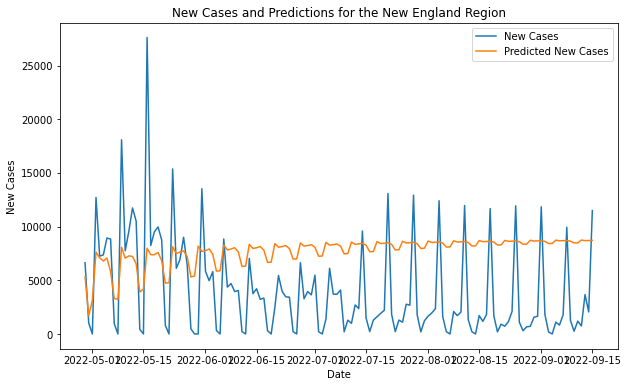

In [44]:
search_auto_arima(ne_train, ne_test, region = "New England")

# Pacific

m =  1  done
18202.904741093313
m =  2  done
18224.391544451282
m =  7  done
17474.07533613148
M =  7
(6, 1, 3)
(5, 0, 2, 7)
MAE: 14482.408801656367
RMSE: 19217.331831248197
MASE: 2.1515155543244955
                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  819
Model:             SARIMAX(6, 1, 3)x(5, 0, [1, 2], 7)   Log Likelihood               -8720.038
Date:                                Tue, 12 Mar 2024   AIC                          17474.075
Time:                                        01:28:02   BIC                          17554.092
Sample:                                    01-26-2020   HQIC                         17504.782
                                         - 04-23-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err         

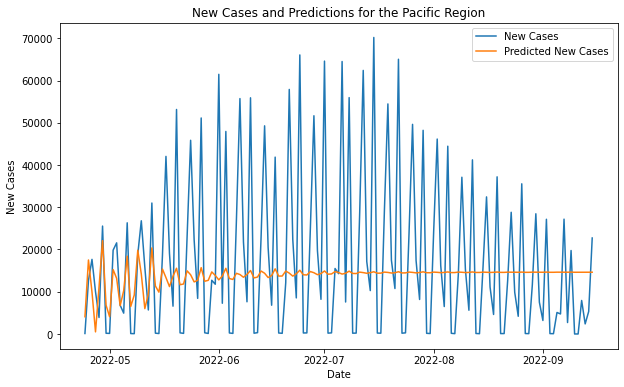

In [53]:
search_auto_arima(pac_train, pac_test, region = "Pacific")

# South Atlantic

m =  1  done
18611.455410962866
m =  2  done
18535.689128761638
m =  7  done
18325.482279503354
M =  7
(6, 1, 3)
(4, 0, 0, 7)
MAE: 14753.300924326242
RMSE: 21214.848602345523
MASE: 1.4151288561727622
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  822
Model:             SARIMAX(6, 1, 3)x(4, 0, [], 7)   Log Likelihood               -9148.741
Date:                            Tue, 12 Mar 2024   AIC                          18325.482
Time:                                    00:56:16   BIC                          18391.430
Sample:                                01-22-2020   HQIC                         18350.785
                                     - 04-22-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      

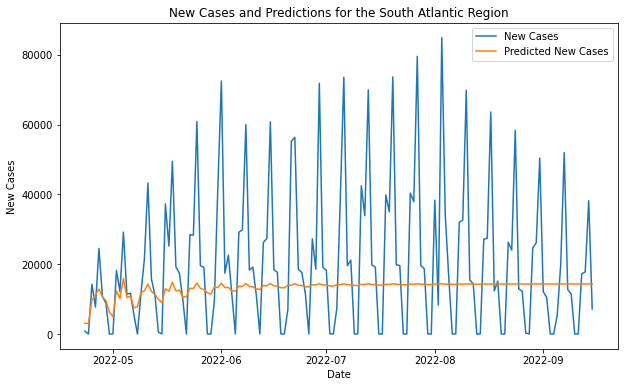

In [46]:
search_auto_arima(satl_train, satl_test, region = "South Atlantic")

# West North Central

m =  1  done
15671.411401365773
m =  2  done
15979.49377377721
m =  7  done
15631.066439627262
M =  7
(4, 1, 2)
(3, 0, 1, 7)
MAE: 3899.725264144538
RMSE: 5548.611203538777
MASE: 1.1889184934253096
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  787
Model:             SARIMAX(4, 1, 2)x(3, 0, [1], 7)   Log Likelihood               -7804.533
Date:                             Tue, 12 Mar 2024   AIC                          15631.066
Time:                                     01:08:02   BIC                          15682.403
Sample:                                 03-04-2020   HQIC                         15650.804
                                      - 04-29-2022                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025 

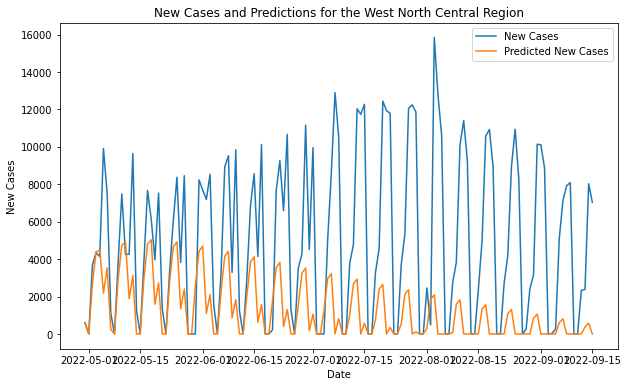

In [51]:
search_auto_arima(wnc_train, wnc_test, region = "West North Central")

# West South Central

m =  1  done
17132.328254319724
m =  2  done
17229.912055412045
m =  7  done
16968.433567601805
M =  7
(2, 1, 2)
(1, 0, 0, 7)
MAE: 8684.538938550904
RMSE: 11618.184818960499
MASE: 1.9315730593449685
                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  809
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 7)   Log Likelihood               -8478.217
Date:                            Tue, 12 Mar 2024   AIC                          16968.434
Time:                                    01:00:54   BIC                          16996.601
Sample:                                02-07-2020   HQIC                         16979.249
                                     - 04-25-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0

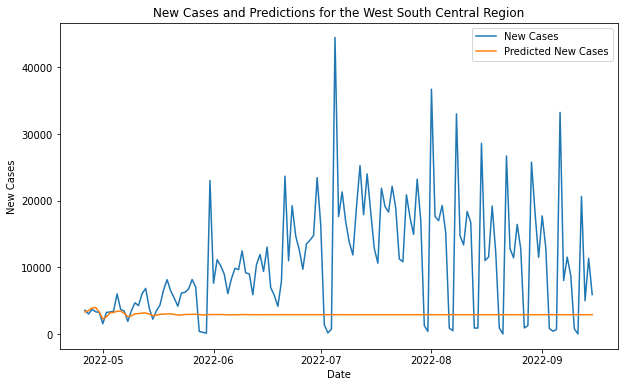

In [48]:
search_auto_arima(wsc_train, wsc_test, region = "West South Central")